# グリッド細胞の発火パターンをPythonで可視化する
> 
- toc: true 
- badges: true
- comments: true
- categories: [neuroscience]
- author: 山拓
- image: 

## 概要
Edvard Moser博士の研究室が公開している、グリッド細胞の活動をPythonで可視化してみました。データは<https://www.ntnu.edu/kavli/research/grid-cell-data>からダウンロードできます。

コードを書く上で<http://felix11h.github.io/blog/grid-cell-rate-maps>を参考にしました。一部の関数はこのブログから引用しています。今回は上記のサイトで実装されていない、Gaussian kernelを用いたSmoothed rate mapとAutocorrelation mapの実装をしてみます。

> Important: 著者はGrid cellsの研究をしていません。実際の研究で用いられるコードと異なる可能性があります。

## グリッド細胞(Grid Cells)について
実装とは関係ないですが、グリッド細胞についてまとめておきます。

### 空間基底としてのグリッド細胞
詳しくは[場所細胞 - 脳科学辞典](https://bsd.neuroinf.jp/wiki/場所細胞#.E5.86.85.E5.81.B4.E5.97.85.E5.86.85.E7.9A.AE.E8.B3.AA.E3.81.AE.E6.A0.BC.E5.AD.90.E7.B4.B0.E8.83.9E)や[2014年のノーベル生理学・医学賞の解説（神経科学学会）](https://www.jnss.org/141031-03/)、[Grid cells (Scholarpedia)](http://www.scholarpedia.org/article/Grid_cells)などをお読みいただければと思います。簡単にまとめると、海馬には場所特異的に発火する**場所細胞**(place cell)があり、これはO'keefe博士によって発見されました。次にMay-Britt Moser博士とEdvard Moser博士は六角形格子状の場所受容野を持つ**グリッド細胞**(格子細胞, grid cell)を内側嗅内皮質(medial entorhinal cortex; MEC)で発見しました。この3人は2014年のノーベル生理学・医学賞を受賞しています。



![](images/grid_cells_figs/1543060133.jpg)

<http://www.scholarpedia.org/article/Grid_cells>より。左図の黒線はラットの経路、赤は発火が生じた位置。右図は発火率マップ(rate map)。

最近、外側膝状体背側核(dorsal lateral geniculate nucleus)で場所細胞が見つかったそうです（V Hok, et al., 2018, [bioRxiv](https://www.biorxiv.org/content/early/2018/11/19/473520)）。

## データについて

公開されているデータはMatLabのmatファイル形式です。しかし、[scipy.io.loadmat](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html)を用いることでpythonでデータの中身を取得することができます。

使用するデータは以下の通りです。

- [10704-07070407_POS.mat](https://github.com/Salad-bowl-of-knowledge/hp/blob/master/_notebooks/data/grid_cells_data/10704-07070407_POS.mat)
- [10704-07070407_T2C3.mat](https://github.com/Salad-bowl-of-knowledge/hp/blob/master/_notebooks/data/grid_cells_data/10704-07070407_T2C3.mat)

これらのファイルは<https://archive.norstore.no/pages/public/datasetDetail.jsf?id=8F6BE356-3277-475C-87B1-C7A977632DA7>からダウンロードできるファイルの一部です。ただし全体で2.23GBあるので、簡単に試したい場合は上記のリンクからダウンロードしてください。以下では`./data/grid_cells_data/`ディレクトリの下にファイルを置いています。

データの末尾の"POS"と"T2C3"の意味について説明しておきます。まず、"POS"はpost, posx, posyを含む構造体でそれぞれ試行の経過時間、x座標, y座標です。座標は-50~50で記録されています。恐らく1m四方の正方形の部屋で、原点を部屋の中心としているのだと思います。"T2C3"はtがtetrode（テトロード電極）でcがcell（細胞）を意味します。後ろの数字は番号付けたものと思われます。 

## Smoothed Rate Mapについて

発火率$\lambda(\boldsymbol{x})$は、場所$\boldsymbol{x}=(x,y)$で記録されたスパイクの回数を、場所$\boldsymbol{x}$における滞在時間(s)で割ることで得られます。 $$ \lambda(\boldsymbol{x})=\frac{\displaystyle \sum_{i=1}^n
g\left(\frac{\boldsymbol{s}_i-\boldsymbol{x}}{h}\right)}{\displaystyle \int_0^T g\left(\frac{\boldsymbol{y}(t)-\boldsymbol{x}}{h}\right)dt} $$ ただし、$n$はスパイクの回数、$T$は計測時間、$g(\cdot)$はGaussain
Kernel（中身の分子が平均、分母が標準偏差）、$\boldsymbol{s}_i$は$i$番目のスパイクの発生した位置、$\boldsymbol{y}(t)$は時刻$t$でのラットの位置です。分母は積分になっていますが、実際には離散的に記録をするので、累積和に変更し、$dt$を時間のステップ幅(今回は0.02s)とします。

Gaussian Kernelを用いて平滑化することで「10cm四方での発火を同じ位置での発火とする」などとした場合よりも、得られるマップは滑らかになります。

### 実装
まず、ライブラリをインポートしてデータを読み込みます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io as io
from tqdm import tqdm
 
# from http://www.ntnu.edu/kavli/research/grid-cell-data
pos = io.loadmat('./data/grid_cells_data/10704-07070407_POS.mat')
spk = io.loadmat('./data/grid_cells_data/10704-07070407_T2C3.mat')

posファイル内の構造は次のようになっています。
- `pos["post"]`: times at which positions were recorded
- `pos["posx"]`: x positions
- `pos["posy"]`: y positions
- `spk["cellTS"]`: spike times

次に種々の関数を実装します。

In [2]:
def nearest_pos(array, value):
    k = (np.abs(array - value)).argmin()
    return k

In [3]:
def GaussianKernel(sizex, sizey, sigma=0.5, center=None):
    """
    sizex  : kernel width
    sizey  : kernel height
    sigma  : gaussian Sd
    center : gaussian mean
    return gaussian kernel
    """
    x = np.arange(0, sizex, 1, float)
    y = np.arange(0, sizey, 1, float)
    x, y = np.meshgrid(x,y)
     
    if center is None:
        x0 = sizex // 2
        y0 = sizey // 2
    else:
        if np.isnan(center[0])==False and np.isnan(center[1])==False:            
            x0 = center[0]
            y0 = center[1]        
        else:
            return np.zeros((sizey,sizex))
 
    return np.exp(-((x-x0)**2 + (y-y0)**2) / 2*sigma**2)

In [4]:
def smoothed_rate_map(pos, spk, kernel_sigma=0.1, 
                      W=100, H=100):
     
    # load datas
    posx = pos["posx"].flatten()
    posy = pos["posy"].flatten()
    spkt = spk["cellTS"].flatten()
 
    #change positions range: -50 ~ 50 -> 0 ~ H or W
    posx = (posx + 50) / 100 * W
    posy = (posy + 50) / 100 * H
     
    # find nearest positions when spikes occur
    indx = [nearest_pos(pos["post"],t) for t in spkt]
    indy = [nearest_pos(pos["post"],t) for t in spkt]
     
    # occup position while trajectory 
    occup_m_list = []
    for i in tqdm(range(len(posx))):
        occup_m_list.append(GaussianKernel(W, H, kernel_sigma,
                                           (posx[i], posy[i])))
    occup_m = sum(occup_m_list)
    occup_m *= 0.02 # one time step is 0.02s 
    occup_m[occup_m==0] = 1 # avoid devide by zero
     
    # activation
    activ_m_list = []
    for i in tqdm(range(len(spkt))):
        activ_m_list.append(GaussianKernel(W, H, kernel_sigma,
                                           (posx[indx][i] ,posy[indy][i])))
    activ_m = sum(activ_m_list)
     
    rate_map = activ_m / occup_m
 
    return rate_map

最後に実行します。

100%|█████████████████████████████████████████████████████████████████████████████| 2326/2326 [00:02<00:00, 959.91it/s]


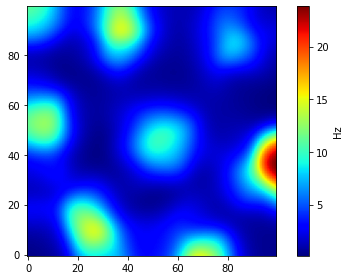

In [5]:
rm = smoothed_rate_map(pos, spk, 0.2, 100, 100)
plt.figure(figsize=(6,4))
plt.imshow(rm, cmap="jet")
plt.colorbar(label="Hz")
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig("smoothed_rate_map.png")
plt.show()

## Autocorrelation Mapについて

https://core.ac.uk/download/pdf/30859910.pdfのSupporting Online Materialに書いてある式通りに実装してみましたが、遅い＆論文と見た目が全く異なるので、[scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)を使いました。

100%|█████████████████████████████████████████████████████████████████████████████| 2326/2326 [00:02<00:00, 929.87it/s]


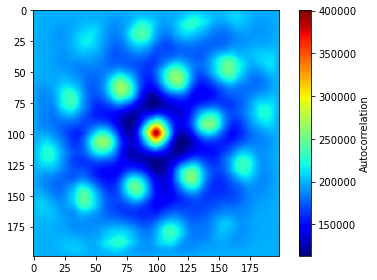

In [6]:
from scipy.signal import correlate2d
 
rm = smoothed_rate_map(pos, spk, 0.5, 100, 100)    
a_corr = correlate2d(rm, rm, fillvalue=5)
 
plt.figure(figsize=(6,4))
plt.imshow(a_corr, cmap="jet")
plt.colorbar(label="Autocorrelation")
plt.tight_layout()
# plt.savefig("autocorr.png")
plt.show()

若干論文と図が異なる上、cross-correlationが-1~1の範囲でないのはおかしい気がするのですが、六角形格子が見えているので良しとします。

## 参考にした文献・サイト
- <https://github.com/Felix11H/grid_cell_rate_map>
- <https://www.ntnu.edu/kavli/research/grid-cell-data>
- <https://core.ac.uk/download/pdf/30859910.pdf>のSupporting Online Material
- <https://github.com/MattNolanLab/gridcells>
- <https://arxiv.org/pdf/1810.07429.pdf>